In [2]:
%load_ext autoreload

%autoreload 2

from vae_dist.core.VAE import baselineVAEAutoencoder
from vae_dist.core.training import train
from vae_dist.dataset.dataset import FieldDataset
import torch 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'pytorch_lightning'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
root = "../../data/cpet/"
# load model to gpu
dataset_vanilla = FieldDataset(
    root, 
    transform=None, 
    augmentation=None, 
    device=device
    )


dataset_loader_full = torch.utils.data.DataLoader(dataset_vanilla, batch_size=40, shuffle=True)


In [ ]:
model = baselineVAEAutoencoder(
    irreps = None, # not used rn 
    in_channels = 3,
    out_channels = 16,
    kernel_size = 5,
    stride = 1,
    padding = 0,
    dilation = 1,
    groups = 1,
    bias = True,
    padding_mode = 'zeros',
    #padding_mode = 'constant',
    latent_dim = 4, # final vae hidden layer 
    num_layers = 2, # not used rn 
    hidden_dim = 32,
    activation = 'relu', # not used rn 
    dropout = 0.1, # not used rn 
    batch_norm = False, # not used rn 
    beta = 1.0,
    device = device, 
    loss = 'elbo'
)

In [ ]:
train(model, dataset_loader_full, device = device, epochs = 100)

# Lightning Implementation

In [1]:
%load_ext autoreload
%autoreload 2

import pytorch_lightning as pl
from vae_dist.core.CNN import CNNAutoencoderLightning
from vae_dist.dataset.dataset import FieldDataset
from pytorch_lightning.callbacks import LearningRateMonitor
import torch 

/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
root = "../../data/cpet/"
# load model to gpu
dataset_vanilla = FieldDataset(
    root, 
    transform=None, 
    augmentation=None, 
    device=device
    )

#torch.multiprocessing.set_start_method('spawn')# good solution !!!!

# train test split - randomly split dataset into train and test
train_size = int(0.8 * len(dataset_vanilla))
test_size = len(dataset_vanilla) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_vanilla, [train_size, test_size])


dataset_loader_full = torch.utils.data.DataLoader(
    dataset_vanilla, 
    batch_size=40,
    shuffle=True,
    num_workers=0
)

dataset_loader_train= torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=10,
    shuffle=True,
    num_workers=0
)

dataset_loader_test= torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=10,
    shuffle=True,
    num_workers=0
)



In [3]:
model = CNNAutoencoderLightning(
    irreps = None, # not used rn 
    in_channels = 3,
    out_channels = 16,
    kernel_size = 5,
    stride = 1,
    padding = 0,
    dilation = 1,
    groups = 1,
    bias = True,
    padding_mode = 'zeros',
    latent_dim = 4, # final vae hidden layer 
    num_layers = 2, # not used rn 
    hidden_dim = 32,
    activation = 'relu', # not used rn 
    dropout = 0.1, # not used rn 
    batch_norm = False, # not used rn 
    beta = 1.0,
    device = device,
    learning_rate = 0.01,
)

In [4]:
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = pl.Trainer(
    limit_train_batches=100, 
    max_epochs=100, 
    accelerator='gpu', 
    devices = [0],
    accumulate_grad_batches=5, 
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose = False),
        lr_monitor]
    )

trainer.fit(model, dataset_loader_train, dataset_loader_test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 2.5 M 
1 | decoder | Sequential | 2.6 M 
---------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.486    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:491: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,
/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1599: PossibleUserWarning: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Epoch 88: 100%|██████████| 37/37 [00:00<00:00, 210.83it/s, loss=185, v_num=18]     


/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:442: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=Poss

7.585775750291837e-08

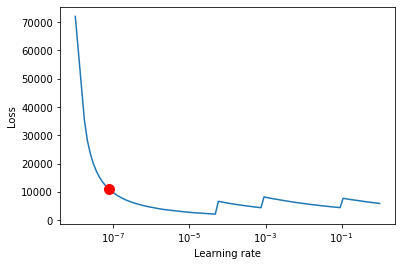

In [39]:

trainer_lr = pl.Trainer(auto_lr_find=True, max_epochs=100, gpus=1)
lr_finder = trainer_lr.tuner.lr_find(model, dataset_loader_train, dataset_loader_test)
fig = lr_finder.plot(suggest=True)
fig.show()
lr_finder.suggestion()
#trainer.tune(model)
#model.learning_rate

In [16]:

trainer_lr = pl.Trainer(accelerator='gpu', devices = [0], accumulate_grad_batches=5, auto_lr_find=True)
trainer_lr.fit(model, dataset_loader_train, dataset_loader_test)
#lr_finder = trainer_lr.tuner.lr_find(model)
#fig = lr_finder.plot(suggest=True)
#fig.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/pytorch_lightning/loops/utilities.py:97: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 2.5 M 
1 | decoder | Sequential | 2.6 M 
---------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.486    Total estimated model params size (MB)


/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:491: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,
/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottle

Epoch 999: 100%|██████████| 37/37 [00:00<00:00, 333.57it/s, loss=292, v_num=21]     

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 37/37 [00:00<00:00, 201.26it/s, loss=292, v_num=21]


# VAE Lightning

In [2]:
from vae_dist.core.VAE import baselineVAEAutoencoder

%load_ext autoreload
%autoreload 2

import pytorch_lightning as pl
from vae_dist.dataset.dataset import FieldDataset
from pytorch_lightning.callbacks import LearningRateMonitor
import torch 

/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
root = "../../data/cpet/"
# load model to gpu
dataset_vanilla = FieldDataset(
    root, 
    transform=None, 
    augmentation=None, 
    device=device
    )

#torch.multiprocessing.set_start_method('spawn')# good solution !!!!

# train test split - randomly split dataset into train and test
train_size = int(0.8 * len(dataset_vanilla))
test_size = len(dataset_vanilla) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_vanilla, [train_size, test_size])


dataset_loader_full = torch.utils.data.DataLoader(
    dataset_vanilla, 
    batch_size=40,
    shuffle=True,
    num_workers=0
)

dataset_loader_train= torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=10,
    shuffle=True,
    num_workers=0
)

dataset_loader_test= torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=10,
    shuffle=True,
    num_workers=0
)


In [23]:
vae = baselineVAEAutoencoder(
    irreps = None, # not used rn 
    in_channels = 3,
    out_channels = 16,
    kernel_size = 5,
    stride = 1,
    padding = 0,
    dilation = 1,
    groups = 1,
    bias = True,
    padding_mode = 'zeros',
    latent_dim = 4, # final vae hidden layer 
    num_layers = 2, # not used rn 
    hidden_dim = 32,
    activation = 'relu', # not used rn 
    dropout = 0.1, # not used rn 
    batch_norm = False, # not used rn 
    beta = 1.0,
    device = device,
    learning_rate = 0.001
)
trainer = pl.Trainer(gpus=1, max_epochs=30)
trainer.fit(vae, dataset_loader_train, dataset_loader_test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | fc_mu   | Linear     | 2.5 M 
1 | fc_var  | Linear     | 2.5 M 
2 | encoder | Sequential | 6.0 K 
3 | decoder | Sequential | 2.6 M 
---------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.548    Total estimated model params size (MB)


Epoch 0:  28%|██▊       | 8/29 [04:24<11:33, 33.05s/it, loss=1.99e+11, v_num=40] 


ValueError: Expected parameter scale (Tensor of shape (10, 32)) of distribution Normal(loc: torch.Size([10, 32]), scale: torch.Size([10, 32])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[5.6074e-01, 2.8725e-01, 3.4778e-01, 3.7265e-01, 2.7217e-01, 8.6194e-01,
         4.2021e-01, 6.1540e-01, 5.0851e-01, 3.1090e-01, 2.5962e-01, 2.7295e-01,
         2.5502e-01, 3.6191e-01, 4.5074e-01, 4.0503e-01, 3.7563e-01, 3.6719e-01,
         3.7209e-01, 2.6678e-01, 5.9318e-01, 5.3631e-01, 3.2544e-01, 2.2601e-01,
         4.4353e-01, 2.5320e-01, 4.5085e-01, 3.6082e-01, 3.0879e-01, 5.5971e-01,
         4.9405e-01, 3.4750e-01],
        [7.6514e-01, 7.6289e-01, 7.3498e-01, 7.6757e-01, 5.4888e-01, 1.0780e+00,
         6.3804e-01, 8.1713e-01, 1.2171e+00, 6.7644e-01, 6.7080e-01, 5.9911e-01,
         6.6003e-01, 6.2329e-01, 1.0461e+00, 6.1720e-01, 7.6741e-01, 7.6627e-01,
         6.6525e-01, 6.9646e-01, 8.0343e-01, 7.4814e-01, 6.2838e-01, 5.8326e-01,
         6.9730e-01, 6.2501e-01, 6.9498e-01, 6.5162e-01, 6.0239e-01, 7.7598e-01,
         7.3291e-01, 6.1232e-01],
        [3.2665e-02, 4.3015e-02, 4.4195e-02, 6.1899e-02, 5.5789e-03, 1.5414e-01,
         9.6356e-03, 3.6877e-02, 2.7483e-01, 2.8343e-02, 3.4827e-02, 1.5150e-02,
         3.3985e-02, 1.6897e-02, 1.5092e-01, 9.2074e-03, 6.2242e-02, 6.1188e-02,
         1.0748e-02, 3.6200e-02, 4.1396e-02, 3.1716e-02, 8.8537e-03, 1.4071e-02,
         2.6375e-02, 2.6747e-02, 1.2783e-02, 2.5835e-02, 6.6343e-03, 3.3068e-02,
         3.0170e-02, 1.3684e-02],
        [8.3379e-01, 7.6398e-01, 9.1090e-01, 9.6201e-01, 6.7338e-01, 1.1785e+00,
         7.3362e-01, 8.8848e-01, 1.1357e+00, 8.2027e-01, 6.9933e-01, 7.0585e-01,
         6.6902e-01, 8.1132e-01, 1.0093e+00, 7.1613e-01, 9.5998e-01, 9.9003e-01,
         8.7033e-01, 7.0074e-01, 8.5759e-01, 9.2940e-01, 7.8037e-01, 6.3572e-01,
         8.8843e-01, 6.4847e-01, 7.9280e-01, 7.9467e-01, 7.3082e-01, 8.4703e-01,
         9.1469e-01, 7.8461e-01],
        [3.6605e-04, 1.8229e-06, 2.0475e-03, 4.7173e-03, 4.4749e-05, 4.0856e-02,
         3.4350e-04, 5.8419e-04, 3.5253e-05, 5.0179e-04, 1.9109e-06, 4.2930e-05,
         2.3307e-06, 7.5691e-04, 2.6894e-05, 2.7842e-04, 8.5619e-03, 6.3946e-03,
         1.0467e-03, 1.7476e-06, 4.0787e-04, 1.1375e-02, 1.5742e-04, 1.9764e-06,
         4.3740e-03, 3.2210e-06, 2.6666e-04, 6.4308e-04, 8.7734e-05, 3.7433e-04,
         9.3748e-03, 5.1889e-04],
        [6.0411e-20, 0.0000e+00, 2.9393e-02, 3.4464e+03, 1.1648e-19, 1.9908e-03,
         2.8654e-19, 1.6228e-22, 1.0734e-42, 3.2472e-13, 0.0000e+00, 1.0993e-25,
         0.0000e+00, 7.9197e-16, 6.7683e-43, 1.5610e-18, 2.1801e+06, 5.3252e+05,
         9.4358e-15, 0.0000e+00, 2.9404e-21, 1.9890e-10, 1.0555e-18, 0.0000e+00,
         3.8014e-13, 0.0000e+00, 1.2837e-19, 1.4349e-15, 1.8493e-19, 4.7813e-20,
         2.7426e-12, 7.8435e-19],
        [2.6098e-01, 1.2368e-01, 4.9007e-01, 7.0046e-01, 1.4205e-01, 7.0817e-01,
         2.4195e-01, 2.9552e-01, 2.7868e-01, 2.7703e-01, 1.0085e-01, 1.7409e-01,
         9.0759e-02, 4.2809e-01, 2.5736e-01, 2.2880e-01, 7.1906e-01, 6.3564e-01,
         4.9630e-01, 1.0225e-01, 2.4795e-01, 7.9825e-01, 2.2116e-01, 1.0193e-01,
         5.3871e-01, 1.0867e-01, 2.5201e-01, 3.3489e-01, 1.8592e-01, 3.0929e-01,
         6.7096e-01, 3.6450e-01],
        [8.6777e-01, 8.0322e-01, 9.2022e-01, 9.6998e-01, 6.9284e-01, 1.2004e+00,
         7.6920e-01, 9.1880e-01, 1.1682e+00, 8.3030e-01, 7.2498e-01, 7.2455e-01,
         7.0668e-01, 7.9526e-01, 1.0470e+00, 7.4680e-01, 9.6388e-01, 9.8772e-01,
         8.5914e-01, 7.3644e-01, 8.9028e-01, 9.1960e-01, 7.9143e-01, 6.6784e-01,
         8.7327e-01, 6.8052e-01, 8.2445e-01, 8.0122e-01, 7.5363e-01, 8.7387e-01,
         9.1059e-01, 7.7333e-01],
        [5.7221e-05, 9.6137e-10, 3.4005e+00, 4.5710e+01, 9.7215e-05, 1.4940e-01,
         8.2537e-05, 1.8138e-05, 5.8216e-08, 2.1767e-02, 6.4495e-10, 4.2185e-05,
         8.2099e-10, 2.3474e-04, 3.6756e-08, 1.0737e-04, 1.2288e+02, 1.2146e+02,
         2.8269e-04, 6.1196e-10, 2.6223e-05, 1.5377e-03, 1.7818e-04, 1.8856e-09,
         6.2675e-04, 1.2442e-09, 8.0998e-05, 2.9331e-04, 1.2841e-04, 4.7653e-05,
         9.5914e-04, 4.6535e-05],
        [8.1250e-01, 7.8120e-01, 9.0188e-01, 9.7769e-01, 6.3905e-01, 1.1113e+00,
         6.9280e-01, 8.5058e-01, 1.1329e+00, 8.3771e-01, 7.1455e-01, 7.0784e-01,
         7.0050e-01, 7.1353e-01, 1.0250e+00, 6.8427e-01, 9.5482e-01, 9.9763e-01,
         7.3535e-01, 7.2395e-01, 8.3399e-01, 8.1253e-01, 7.0790e-01, 6.5680e-01,
         7.8060e-01, 6.7418e-01, 7.6160e-01, 7.3975e-01, 6.8889e-01, 8.2607e-01,
         7.9312e-01, 6.8589e-01]], device='cuda:0', grad_fn=<ExpBackward0>)